Prototype WIP.

# Topic Evaluation

Evaluate topic assignment to Posts.

In [3]:
import os, sys, ast
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23

## Loading

In [4]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

In [5]:
data_path = "/Data/CSVData"
model_path = "../models"
figures_path = "../reports/figures/"

In [6]:
topics40_fpath = os.path.join(data_path, "topics", "topics.csv")
_, res = user_dbx.files_download(topics40_fpath)
topics40 = pd.read_csv(res.raw)

print("Topics n40", topics40.shape)

Topics n40 (22534, 4)


## Exploration

NaN Stats

In [17]:
topics40.isna().sum()

text                  0
textID                0
topic_distribution    0
topic                 0
dtype: int64

Duplicated texts (after cleaning)

In [18]:
topics40.text.duplicated().value_counts()

False    22534
Name: text, dtype: int64

Duplicated textIDs

In [19]:
topics40.textID.duplicated().value_counts()

False    22534
Name: textID, dtype: int64

Topics

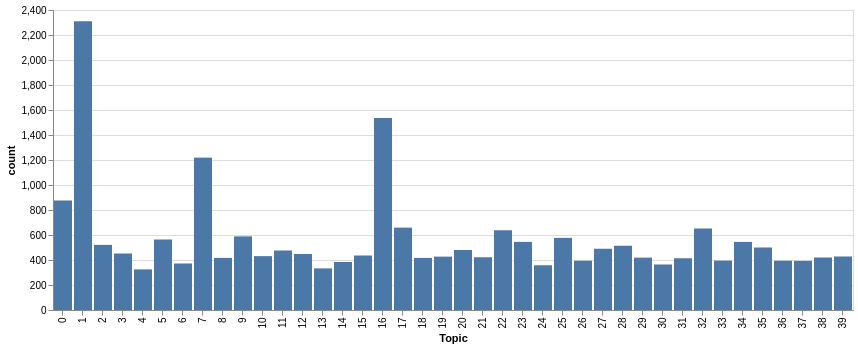

In [20]:
p_data = topics40.topic.value_counts().to_frame("count").rename_axis("Topic").reset_index()

chart = alt.Chart(p_data).mark_bar().encode(
    x="Topic:O",
    y="count:Q"
)

chart.save(os.path.join(figures_path, "topics", "posts_per_topic.html"))
chart

Top-10 Posts per Topic

In [ ]:
def get_top_10(df, topic, topic_range):
    topic_subset = df[df.topic == topic].copy()
    topic_subset.topic_distribution = topic_subset.topic_distribution.apply(ast.literal_eval)
    flattend_subset = pd.concat([topic_subset,
                                 pd.DataFrame(topic_subset.topic_distribution.values.tolist(),
                                              index=topic_subset.index, columns=topic_range)],
                                axis=1)
    return flattend_subset.sort_values(by=[topic], ascending=False).text.head(10)

In [ ]:
topics40_top10_fp = "../reports/topics_40_top-10.txt"
topic_range = range(0, 40)

with open(topics40_top10_fp, "w") as f:
    for i in topic_range:
        with pd.option_context("display.max_colwidth", -1):
            f.write("Topic " + str(i) + ":\n" + get_top_10(topics40, i, topic_range).to_string(index=False) + "\n\n")

# Conclusion

